# Lab 6: K-Means vs. Variational Mixture of Gaussians (VMoG)

In this lab, you will explore two clustering algorithms:
- **K-Means Clustering**: A hard clustering method that assigns each point to a single cluster.
- **Variational Mixture of Gaussians (VMoG)**: A probabilistic clustering method that models soft cluster assignments.

We will use the **Wine dataset** and compare how these methods cluster different types of wine.


### Wine Dataset 🍷
<div>
<img src="image.jpg" width="600"/>
</div>

The Wine dataset is a classic machine learning dataset that contains chemical analyses of wines grown in the same region in Italy but derived from three different cultivars. The dataset includes 13 features:

1. Alcohol content 🍷 (alcohol percentage)
2. Malic acid 🍎 (tart, crisp taste)
3. Ash 🧪 (mineral content)
4. Alcalinity of ash ⚗️ (pH balance)
5. Magnesium 🔬 (mineral content)
6. Total phenols 🌿 (antioxidants)
7. Flavanoids 🍇 (color compounds)
8. Nonflavanoid phenols 🌱 (other phenols)
9. Proanthocyanins 🎨 (color pigments)
10. Color intensity 🎯 (wine color)
11. Hue 🌈 (color shade)
12. OD280/OD315 of diluted wines 📊 (protein content)
13. Proline ⚛️ (amino acid)

The dataset consists of 178 samples, with each sample belonging to one of three different wine classes: Barolo, Grignolino, and Barbera.

#### Barolo 👑 - King of Wines
- Higher alcohol content 🍷
- Higher levels of phenols and flavanoids 🌿
- Deep, rich color intensity 🎨
- High proline content ⚛️

#### Grignolino 🌺 - Light and Aromatic Red
- Medium alcohol content 🍷
- Higher acidity (malic acid) 🍎
- Lighter color intensity 🎨
- Lower phenol content 🌿

#### Barbera 🍇 - Bold, High-Acid Red Wine
- Medium-high alcohol content 🍷
- High acidity 🍎
- Deep color intensity 🎨
- Lower tannins (phenols) than Barolo 🌿



In [1]:
# Load Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_normal, mode
from scipy.special import logsumexp

# Set visualization style
sns.set(style='whitegrid')

## Recap: K-Means Clustering
K-Means is a **hard clustering** algorithm that assigns each data point to one of $K$ clusters by minimizing intra-cluster variance. It can be derived as a special case of Variational Mixture of Gaussians (VMoG) by introducing a temperature parameter $\beta$:

$$
    \alpha_k^n = \frac{\exp(-\frac{1}{2\beta} || x^n - \mu_k ||^2)}{\sum_{k'} \exp(-\frac{1}{2\beta} || x^n - \mu_{k'} ||^2)}.
$$

When $\beta \to 0$, the posterior collapses to a hard assignment:

$$
    \hat{z}^n = \arg\min_k || x^n - \mu_k ||^2.
$$

The mean update simplifies to computing the centroid of assigned points:

$$
    \mu_k = \frac{1}{|S_k|} \sum_{x^n \in S_k} x^n,
$$

where $S_k$ is the set of points assigned to cluster $k$.

In [2]:

class KMeansFromScratch:
    def __init__(self, n_clusters=3, max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        np.random.seed(random_state)
        
    def initialize_centroids(self, X):
        """Initialize centroids randomly from data points"""
        n_samples = X.shape[0] # X.shape = [178,13]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False) # indices.shape = [3]
        return X[indices] # X[indices].shape = [3,13]
    
    def assign_clusters(self, X, centroids):
        """Assign each point to nearest centroid"""
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)
    
    def update_centroids(self, X, labels):
        """Update centroids based on mean of assigned points"""
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            if np.sum(labels == k) > 0:  # avoid empty clusters
                centroids[k] = np.mean(X[labels == k], axis=0)
        return centroids
    
    def compute_inertia(self, X, labels, centroids):
        """Compute sum of squared distances to nearest centroids"""
        distances = np.sqrt(((X - centroids[labels])**2).sum(axis=1))
        return np.sum(distances**2)
    
    def fit(self, X, verbose=False):
        """Fit K-means to data"""
        self.centroids_ = self.initialize_centroids(X)
        self.inertia_history_ = []
        
        for iteration in range(self.max_iter):
            # TODO: Assign points to clusters: labels
            labels =
            
            # Store old centroids to check convergence
            old_centroids = self.centroids_.copy()
            
            # TODO: Update centroids: self.centroids_
            self.centroids_ =
            
            # Compute inertia
            inertia = self.compute_inertia(X, labels, self.centroids_)
            self.inertia_history_.append(inertia)
            
            if verbose:
                print(f"Iteration {iteration}: Inertia = {inertia:.4f}")
            
            # Check convergence
            if np.allclose(old_centroids, self.centroids_):
                break
                
        self.labels_ = labels
        return self

In [3]:
# Visualization
def map_clusters_to_labels(true_labels, cluster_labels):
    """
    Maps cluster labels to true labels by maximizing matching frequencies.
    
    Parameters:
    -----------
    true_labels : array-like
        True class labels
    cluster_labels : array-like
        Predicted cluster labels
    
    Returns:
    --------
    dict : Mapping from cluster labels to true labels
    """
    mapping = {}
    unique_clusters = np.unique(cluster_labels)
    remaining_labels = set(np.unique(true_labels))
    
    # For each cluster, find the most common true label
    for cluster in unique_clusters:
        mask = (cluster_labels == cluster)
        if len(remaining_labels) > 0:
            # Find the most common true label in this cluster
            true_label_mode, count = mode(true_labels[mask], keepdims=False)
            
            # If this label is still available, map to it
            if true_label_mode in remaining_labels:
                mapping[cluster] = true_label_mode
                remaining_labels.remove(true_label_mode)
            else:
                # If already taken, map to any remaining label
                mapping[cluster] = remaining_labels.pop()
    
    return mapping


def plot_clustering_with_accuracy(data, cluster_col, title=None):
    """
    Plot clustering results showing correct/incorrect classifications with automatic cluster mapping.
    
    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing 'PC1', 'PC2', 'class', 'target' and clustering results
    cluster_col : str
        Name of the column containing cluster assignments
    title : str, optional
        Plot title. If None, will be generated based on cluster_col
    """
    plt.figure(figsize=(8, 6))
    
    # Create a copy of the data to avoid modifying the original
    plot_data = data.copy()
    
    # Map cluster numbers to true classes
    cluster_mapping = map_clusters_to_labels(
        plot_data['target'].values,
        plot_data[cluster_col].values
    )
    
    # Apply mapping to get aligned cluster labels
    plot_data['aligned_clusters'] = plot_data[cluster_col].map(cluster_mapping)
    
    # Determine correct classifications using aligned clusters
    plot_data['correct'] = (plot_data['aligned_clusters'] == plot_data['target']).map(
        {True: 'Correct', False: 'Incorrect'}
    )
    
    # Create the scatter plot
    sns.scatterplot(data=plot_data, x='PC1', y='PC2', 
                    hue='correct', style='class',
                    markers={'Barolo': 'o', 'Grignolino': 's', 'Barbera': 'v'},
                    palette={'Correct': 'green', 'Incorrect': 'red'},
                    alpha=0.7, s=80)
    
    # Set title
    if title is None:
        title = f'{cluster_col} Results'
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # Modify legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels,
              title='Wine Class',
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Display cluster mapping
    mapping_text = "Cluster mapping:\n" + "\n".join(
        f"Cluster {k} → Class {v}" for k, v in cluster_mapping.items()
    )
    plt.text(0.02, 0.85, mapping_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return cluster_mapping


In [4]:
df_pca['KMeans_Cluster'] = kmeans.labels_
# Visualize K-Means Clusters
plot_clustering_with_accuracy(df_pca, 'KMeans_Cluster', 'K-Means Clustering Results')

NameError: name 'kmeans' is not defined

## Clustering Evaluation Metrics

We use three different metrics to evaluate our clustering results:

### 1. Silhouette Score
The Silhouette Score measures how similar a point is to its own cluster compared to other clusters. Range: [-1, 1]
- **Score = 1**: Perfect clustering (points are far from neighboring clusters)
- **Score = 0**: Points are on or close to decision boundary
- **Score = -1**: Points might be assigned to wrong clusters

### 2. Adjusted Mutual Information (AMI) Score
AMI measures the mutual information between true labels and predicted clusters, adjusted for chance. Range: [0, 1]
- **Score = 1**: Perfect alignment with true labels
- **Score = 0**: Labels are completely independent
- Adjustment for chance ensures random labelings score close to 0

### 3. Adjusted Rand Index (ARI)
ARI measures the similarity between two clusterings, adjusted for chance agreement. Range: [-1, 1]
- **Score ≈ 1**: Strong agreement with true labels
- **Score ≈ 0**: Clusterings are as good as random
- **Score < 0**: Less agreement than expected by chance


### Key Differences
- **Silhouette Score**: Measures cluster quality based on geometry, doesn't need true labels
- **AMI**: Measures information shared between clusterings, accounting for label permutations
- **ARI**: Measures pair-wise agreement between clusterings, more sensitive to number of clusters


In [190]:
# Evaluate Clustering Results
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import confusion_matrix

def evaluate_clustering(true_labels, predicted_labels, method_name):
    """
    Evaluate clustering results using multiple metrics
    """
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    ari = adjusted_rand_score(true_labels, predicted_labels)
    silhouette = silhouette_score(X_scaled, df_pca['KMeans_Cluster'])
    
    print(f"\n{method_name} Clustering Evaluation:")
    print(f"Adjusted Mutual Information Score: {ami:.4f}")
    print(f"Adjusted Rand Score: {ari:.4f}")
    print(f'Silhouette Score: {silhouette:.4f}')
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {method_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


K-Means Clustering Evaluation:
Adjusted Mutual Information Score: 0.8746
Adjusted Rand Score: 0.8975
Silhouette Score: 0.2849


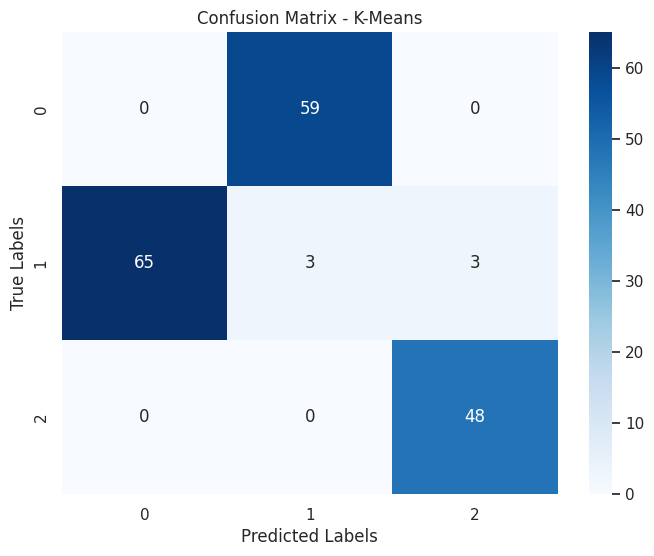

In [191]:
evaluate_clustering(df['target'], df_pca['KMeans_Cluster'], 'K-Means')

## Recap: Variational Mixture of Gaussians (VMoG)
VMoG is a probabilistic clustering model where each data point has a soft assignment to multiple Gaussian components. Given latent variable $z$ representing the component assignment, the generative process follows:

prior: $ p(z) = \frac{1}{M} $, generative distribution: $ \quad p(x | z=k) = \mathcal{N}(x | \mu_k, \Sigma_k), \Sigma_k = I $

The solution to the approximate posterior for $z$:
$$ q(z=k; \phi_n) = \alpha_k^n = \frac{\exp\left(-\frac{1}{2} \| x^n - \mu_k \|^2\right)}{\sum_{k'=1}^K \exp\left(-\frac{1}{2} \| x^n - \mu_{k'} \|^2\right)} $$

The solution to the mean $\mu_k$:
$$ \mu_k = \sum_{n=1}^N \frac{\alpha_k^n}{\sum_{n'=1}^N \alpha_k^{n'}} x^n $$

### **Initialization**
We often use K-Means centroids to initialize $\mu_k, \Sigma_k, p(z)$.

### **Expectation-Maximization (E-M) Algorithm**
The E-M algorithm iteratively updates $\alpha_k^n$ and $\mu_k$ by maximizing the variational lower bound (ELBO):
$$ J = \frac{1}{N} \sum_{n=1}^N (\sum_{m=1}^M \alpha_m^n ( -\frac{1}{2} \| x^n - \mu_m \|^2- \frac{d}{2} \log 2\pi) + \sum_{m=1}^M \alpha_m^n  \log M - \sum_{m=1}^M \alpha_m^n \log \alpha_m ^ n) $$

#### **1. Expectation Step (E-Step)**
Computes the responsibility $\alpha_k^n$: The implementation uses the **log-sum-exp trick** to improve numerical stability when computing the responsibilities:
$$ \log \alpha_k^n = \log p(z=k) + \log \mathcal{N}(x_n | \mu_k, \Sigma_k) - \log Z $$
where $Z$ is the normalization constant.

#### **2. Maximization Step (M-Step)**
Updates the parameters $\mu_k$, covariances ($\Sigma_k$), and weights ($p(z = k)$) to maximize the lower bound:

**Updating Covariances:**
$$ \Sigma_k = \frac{\sum_n \alpha_k^n (x_n - \mu_k)(x_n - \mu_k)^T}{\sum_n \alpha_k^n} $$

**Updating Weights:**
$$ p(z = k) = \frac{\sum_n \alpha_k^n}{N} $$

The model stops updating when the lower bound stops increasing.

Unlike K-Means, VMoG accounts for uncertainty in cluster assignments, making it more flexible for overlapping or elliptical clusters.

In [192]:
class VMoGFromScratch:
    def __init__(self, n_components=3, max_iter=100, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.random_state = random_state
        np.random.seed(random_state)

    def initialize_parameters(self, X, kmeans=None):
        n_samples, n_features = X.shape

        if kmeans is not None:
            # Use custom K-Means results for initialization
            self.means_ = kmeans.centroids_ # from KMeansFromScratch
            labels = kmeans.labels_ # from KMeansFromScratch

            self.covs_ = np.zeros((self.n_components, n_features, n_features))
            self.weights_ = np.zeros(self.n_components)

            for k in range(self.n_components):
                cluster_indices = np.where(labels == k)[0]  # Corrected
                cluster_points = X[cluster_indices]
                n_points = len(cluster_points)

                if n_points > 0:
                    diff = cluster_points - self.means_[k]
                    self.covs_[k] = np.dot(diff.T, diff) / n_points
                    self.covs_[k] += 1e-6 * np.eye(n_features)  # Regularization
                    self.weights_[k] = n_points / n_samples
                else:
                    self.covs_[k] = np.eye(n_features)  # Fallback
                    self.weights_[k] = 1e-6

            self.weights_ /= np.sum(self.weights_)  # Normalize

        else:
            indices = np.random.choice(n_samples, self.n_components, replace=False)
            self.means_ = X[indices]
            self.covs_ = np.array([np.eye(n_features) for _ in range(self.n_components)])
            self.weights_ = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        n_samples = X.shape[0]
        log_resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            try:
                log_likelihood = multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=self.covs_[k] + 1e-6 * np.eye(X.shape[1])
                )
            except np.linalg.LinAlgError:
                print(f"Warning: Singular covariance for component {k}. Resetting.")
                self.covs_[k] += 1e-6 * np.eye(X.shape[1])
                log_likelihood = multivariate_normal.logpdf(X, mean=self.means_[k], cov=self.covs_[k])

            log_resp[:, k] = np.log(np.maximum(self.weights_[k], 1e-10)) + log_likelihood

        # Use stable softmax computation
        log_resp -= logsumexp(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp)

        return resp

    def m_step(self, X, resp):
        n_samples = X.shape[0]
        nk = resp.sum(axis=0) + 1e-10  # Avoid division by zero
        # using Bayesian prior to prevent weights from collapsing to zero
        alpha_prior = 1e-2
        self.weights_ = (nk + alpha_prior) / (n_samples + self.n_components * alpha_prior)

        # Q: what about not using a prior?
        # hint: self.weights_ = nk / n_samples

        self.means_ = np.dot(resp.T, X) / nk[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_diff = diff.T @ np.diag(resp[:, k]) @ diff / nk[k]  # Corrected
            self.covs_[k] = weighted_diff + 1e-3 * np.eye(X.shape[1])  # Regularization

    def compute_lower_bound(self, X, resp):
        n_samples = X.shape[0]
        
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += np.sum(resp[:, k] * (
                np.log(np.maximum(self.weights_[k], 1e-10)) + 
                multivariate_normal.logpdf(X, self.means_[k], self.covs_[k] + 1e-6 * np.eye(X.shape[1]))
            ))

        entropy = -np.sum(resp * np.log(resp + 1e-10))

        return log_likelihood + entropy

    def check_convergence(self, iteration):
        if iteration < 2:
            return False

        current_lb = self.lower_bound_history_[-1]
        previous_lb = self.lower_bound_history_[-2]

        if np.isclose(previous_lb, current_lb):
            return True

        if current_lb < previous_lb:
            print(f"Warning: Lower bound decreased from {previous_lb:.4f} to {current_lb:.4f}")

        return False

    def fit(self, X, verbose=False, kmeans=None):
        self.initialize_parameters(X, kmeans)
        self.lower_bound_history_ = []
        self.n_iter_ = 0

        for iteration in range(self.max_iter):
            # TODO: update responsibilities with E-step
            resp =
            # TODO: M-step
            
            # TODO: compute J
            lower_bound =
            
            self.lower_bound_history_.append(lower_bound)

            if verbose:
                print(f"Iteration {iteration}: Lower bound = {lower_bound:.4f}")

            if self.check_convergence(iteration):
                if verbose:
                    print(f"Converged after {iteration + 1} iterations")
                self.n_iter_ = iteration + 1
                break

        else:
            if verbose:
                print(f"Did not converge after {self.max_iter} iterations")
            self.n_iter_ = self.max_iter

        self.responsibilities_ = resp
        self.labels_ = resp.argmax(axis=1)
        return self


In [193]:
print("\nVMoG Fitting Process:")
vmog = VMoGFromScratch(n_components=3, max_iter=100, random_state=42).fit(X_scaled, kmeans=kmeans, verbose=True)
# Q: what about starting from random initialization?


VMoG Fitting Process:
Iteration 0: Lower bound = -2107.8146
Iteration 1: Lower bound = -2107.7395
Iteration 2: Lower bound = -2107.5570
Iteration 3: Lower bound = -2100.1285
Iteration 4: Lower bound = -2090.4638
Iteration 5: Lower bound = -2090.3510
Iteration 6: Lower bound = -2090.2345
Iteration 7: Lower bound = -2089.9588
Iteration 8: Lower bound = -2089.3936
Iteration 9: Lower bound = -2089.1318
Iteration 10: Lower bound = -2088.9992
Iteration 11: Lower bound = -2087.4729
Iteration 12: Lower bound = -2079.4764
Iteration 13: Lower bound = -2079.4295
Iteration 14: Lower bound = -2079.4209
Converged after 15 iterations


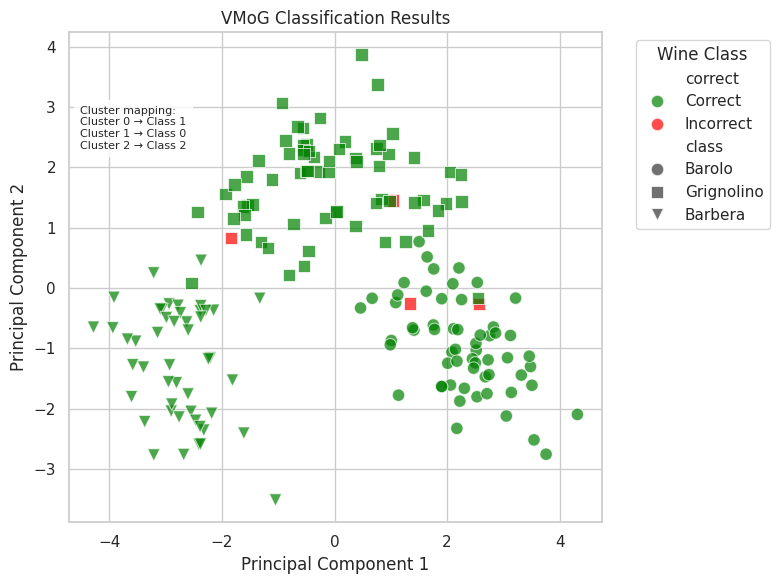

In [194]:
df_pca['VMoG_Cluster'] = vmog.labels_

# Visualize VMoG Clusters
vmog_mapping = plot_clustering_with_accuracy(df_pca, 'VMoG_Cluster', 'VMoG Classification Results')


VMoG Clustering Evaluation:
Adjusted Mutual Information Score: 0.9099
Adjusted Rand Score: 0.9295
Silhouette Score: 0.2849


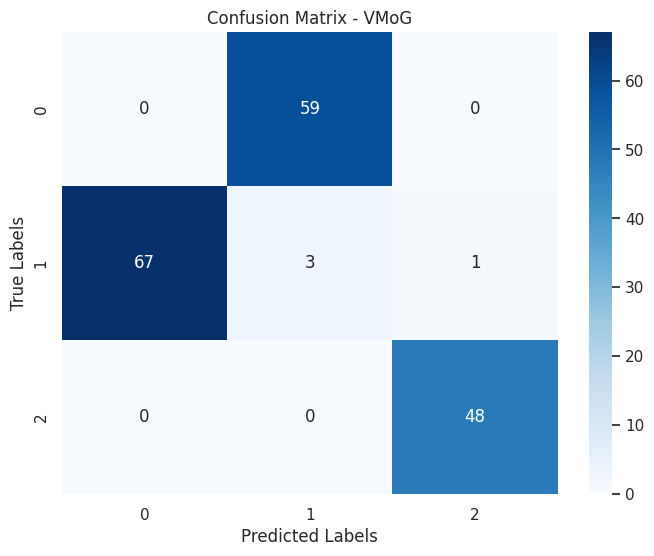

In [195]:
# Evaluate VMoG
evaluate_clustering(df['target'], df_pca['VMoG_Cluster'], 'VMoG')

show the fitting process
leave some blank spaces
hyperparameter sweep: number of clusters
how is it related to variational inference

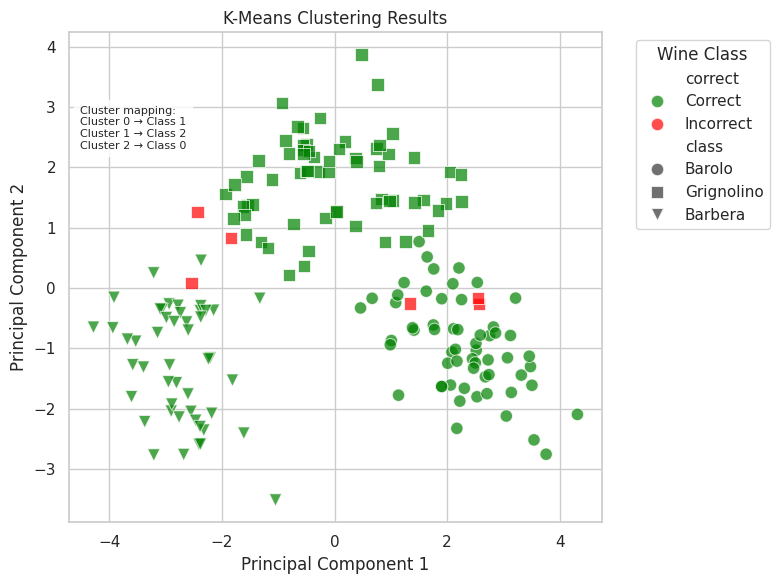

{0: 1, 1: 2, 2: 0}

In [196]:
# Using Sklean K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_pca['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize K-Means Clusters
plot_clustering_with_accuracy(df_pca, 'KMeans_Cluster', 'K-Means Clustering Results')


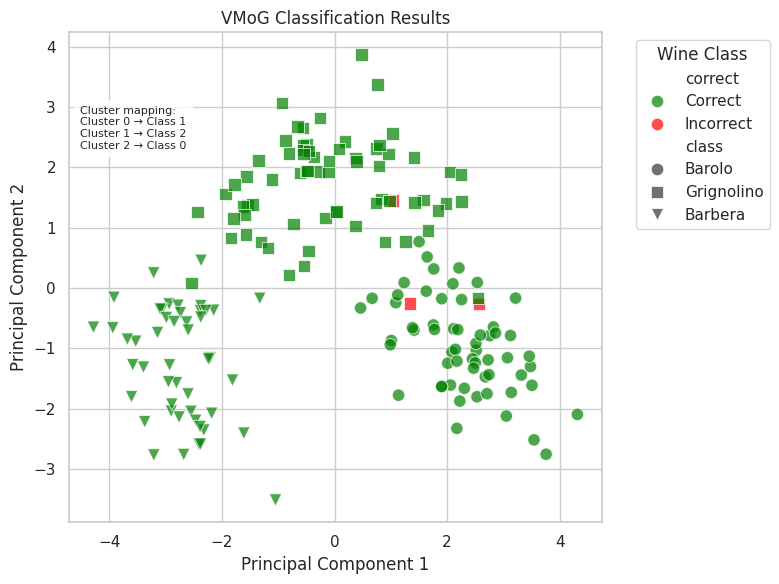

In [197]:
# Using Sklearn BayesianGaussianMixture
vmog = BayesianGaussianMixture(n_components=3, random_state=42)
df_pca['VMoG_Cluster'] = vmog.fit_predict(X_scaled)

# Visualize VMoG Clusters
vmog_mapping = plot_clustering_with_accuracy(df_pca, 'VMoG_Cluster', 'VMoG Classification Results')


K-Means Clustering Evaluation:
Adjusted Mutual Information Score: 0.8746
Adjusted Rand Score: 0.8975
Silhouette Score: 0.2849


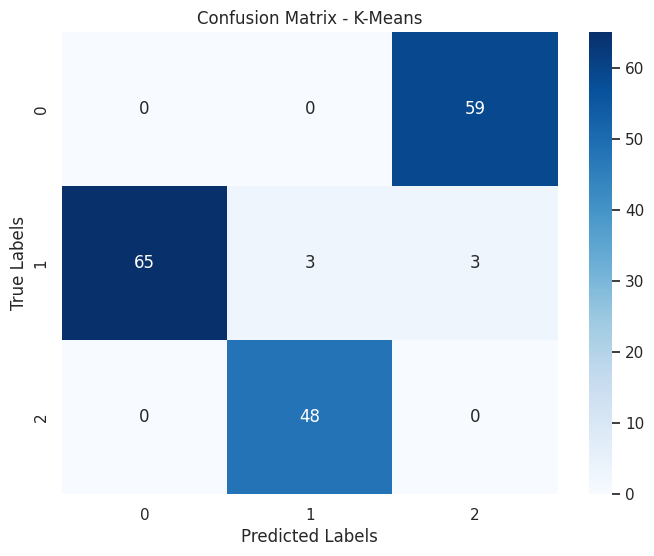


VMoG Clustering Evaluation:
Adjusted Mutual Information Score: 0.9362
Adjusted Rand Score: 0.9459
Silhouette Score: 0.2849


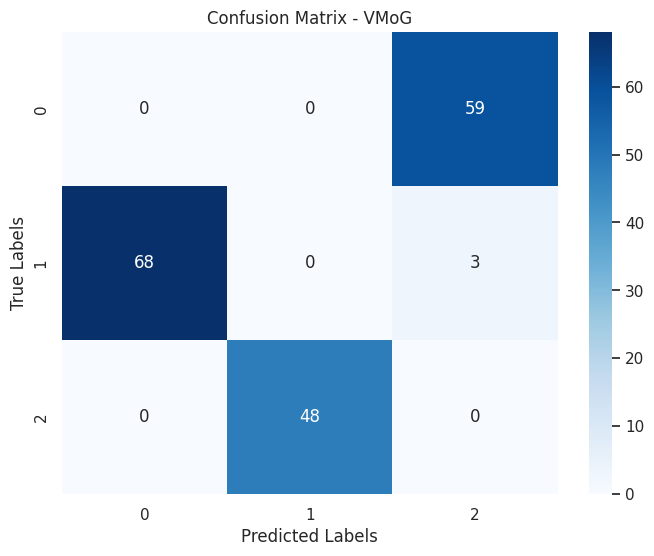

In [198]:
# Evaluate K-Means
evaluate_clustering(df['target'], df_pca['KMeans_Cluster'], 'K-Means')

# Evaluate VMoG
evaluate_clustering(df['target'], df_pca['VMoG_Cluster'], 'VMoG')

## Compare the Two Methods
- Which method assigns clusters more closely to the true wine classes?
- Does VMoG provide **better separation** than K-Means?
